# Handling Missing Values

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

# Load dataset
housing_data = pd.read_csv('housing.csv')

# Visualize the dataset
housing_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [23]:

# Visualize the missing data in the dataset
print("\nPre-Cleaning Missing Data:")
missing_data = housing_data.isnull().sum()
missing_percentage = (missing_data / len(housing_data)) * 100
missing_report = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})
print(missing_report[missing_report['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))



Pre-Cleaning Missing Data:
              Missing Count  Missing Percentage
BuildingArea           6450           47.496318
YearBuilt              5375           39.580265
CouncilArea            1369           10.081001
Car                      62            0.456554


In [24]:
# Handle missing values in 'Car'
housing_data = housing_data.dropna(subset=['Car'])

# Drop the 'CouncilArea' column due to a large number of missing values
housing_data = housing_data.drop(columns=['CouncilArea'])

In [25]:
# Encode non-numeric columns
encoded_housing_data = housing_data.copy()
non_numeric_columns = encoded_housing_data.select_dtypes(exclude=[np.number]).columns
label_encoders = {}

for col in non_numeric_columns:
    label_encoders[col] = LabelEncoder()
    encoded_housing_data[col] = label_encoders[col].fit_transform(encoded_housing_data[col].astype(str))

# Select numeric and encoded columns
numeric_and_encoded_columns = encoded_housing_data.select_dtypes(include=[np.number])

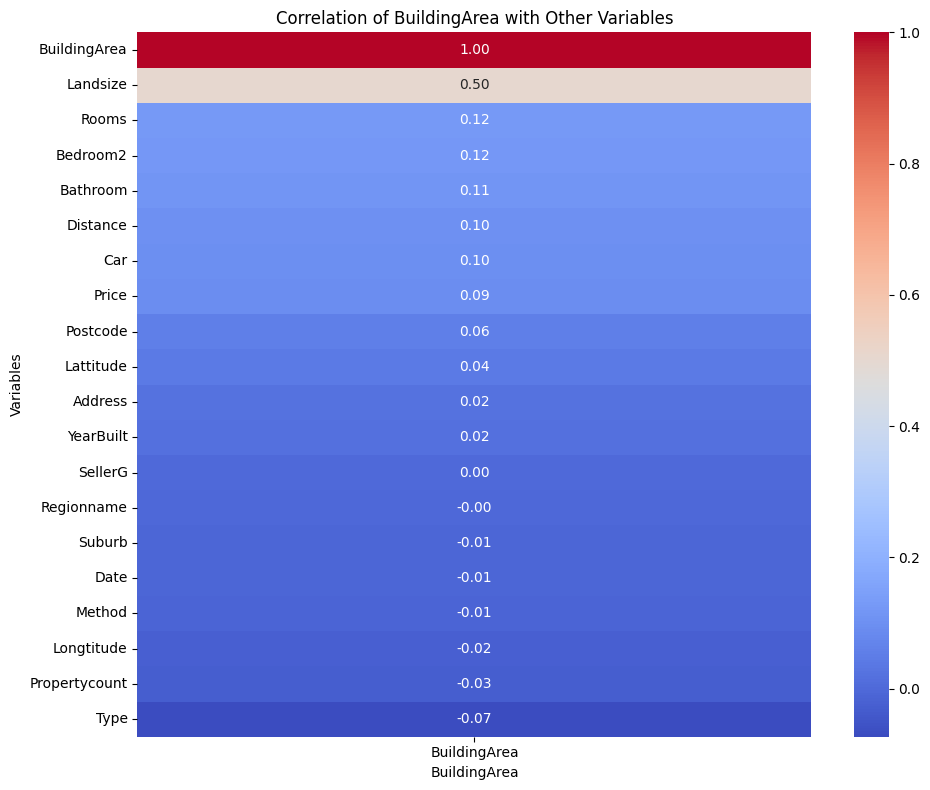

In [26]:
# Compute correlation matrix and visualize correlations with 'BuildingArea'
correlation_matrix_encoded = numeric_and_encoded_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_encoded[['BuildingArea']].sort_values(by='BuildingArea', ascending=False),
    annot=True, cmap='coolwarm', cbar=True, fmt=".2f"
)
plt.title('Correlation of BuildingArea with Other Variables')
plt.xlabel('BuildingArea')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

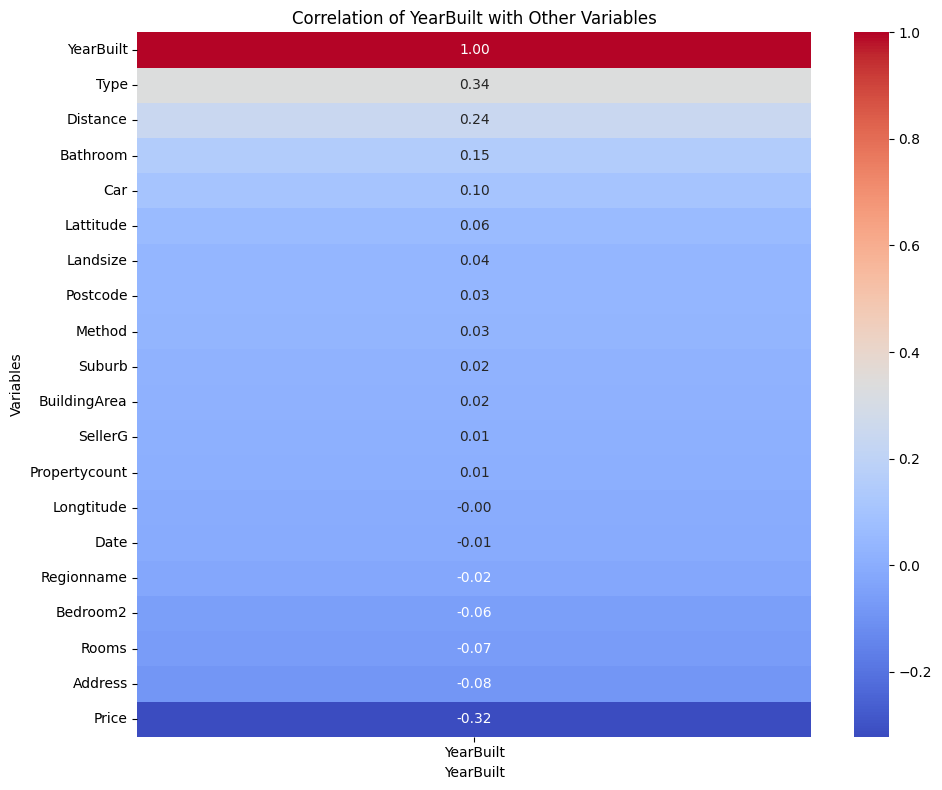

In [27]:
# Compute correlation matrix and visualize correlations with 'YearBuilt'
correlation_matrix_encoded = numeric_and_encoded_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_encoded[['YearBuilt']].sort_values(by='YearBuilt', ascending=False),
    annot=True, cmap='coolwarm', cbar=True, fmt=".2f"
)
plt.title('Correlation of YearBuilt with Other Variables')
plt.xlabel('YearBuilt')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

In [28]:

# Select relevant columns for imputation
columns_for_imputation = ['YearBuilt', 'BuildingArea', 'Rooms', 'Landsize', 'Distance', 'Type']
housing_data_encoded = housing_data.copy()

# Encode non-numeric columns to include in KNN
if 'Type' in columns_for_imputation:
    housing_data_encoded['Type'] = housing_data_encoded['Type'].astype('category').cat.codes

# Apply KNN imputation to selected columns
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(housing_data_encoded[columns_for_imputation])

# Update the original DataFrame with imputed values
housing_data.loc[:, ['YearBuilt', 'BuildingArea']] = imputed_data[:, :2]

# Check for remaining missing values in these columns
print("Remaining Missing Values:")
print(housing_data[['YearBuilt', 'BuildingArea']].isnull().sum())


Remaining Missing Values:
YearBuilt       0
BuildingArea    0
dtype: int64


In [29]:
print("\nPost-Cleaning Missing Data:")
missing_data = housing_data.isnull().sum()
missing_percentage = (missing_data / len(housing_data)) * 100
missing_report = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})
print(missing_report[missing_report['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))


Post-Cleaning Missing Data:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []


In [30]:
# Check for entries where Landsize < BuildingArea
invalid_entries = housing_data[housing_data['Landsize'] < housing_data['BuildingArea']]

# Display the result
print(len(invalid_entries))

2326


In [31]:
landsizes_equal_zero = (housing_data['Landsize'] == 0).sum()
print(f"Number of Landsize values equal to 0: {landsizes_equal_zero}")

Number of Landsize values equal to 0: 1939


In [32]:
# Update Landsize to be equal to BuildingArea where Landsize is 0
housing_data.loc[housing_data['Landsize'] == 0, 'Landsize'] = housing_data['BuildingArea']
housing_data[['BuildingArea', 'Landsize']]

,BuildingArea,Landsize
0,154.6,202.0
1,79.0,156.0
2,150.0,134.0
3,117.4,94.0
4,142.0,120.0
...,...,...
13575,221.0,652.0
13576,133.0,333.0
13577,215.6,436.0
13578,157.0,866.0


In [34]:
housing_data.to_csv('cleaned_data.csv', index=False)

In [42]:
# Function to find outliers (from marta)
def finding_outliers(data, column_name):
    q1 = data[column_name].quantile(0.25)
    q3 = data[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    return outliers

#landsize outliers
outliers_landsize = finding_outliers(housing_data, 'Landsize')
print(outliers_landsize['Landsize'].sort_values(ascending=False), '\n\n sum of outliers:', outliers_landsize['Landsize'].count())
print('\n\n')

#yearbuilt outliers
outliers_yearbuilt = finding_outliers(housing_data, 'YearBuilt')
print(outliers_yearbuilt['YearBuilt'].sort_values(ascending=False), '\n\n sum of outliers:', outliers_yearbuilt['YearBuilt'].count())

11020    433014.0
10504     76000.0
687       75100.0
13245     44500.0
5194      41400.0
           ...   
4028       1388.0
9976       1382.0
5616       1369.0
656        1364.0
5883       1357.0
Name: Landsize, Length: 367, dtype: float64 

 sum of outliers: 367



5363     1885.4
5268     1885.4
2625     1885.0
10400    1885.0
3606     1885.0
          ...  
5936     1817.2
9344     1816.0
9642     1814.2
8448     1812.2
9968     1196.0
Name: YearBuilt, Length: 107, dtype: float64 

 sum of outliers: 107


In [45]:
# Identify the indices of the outliers
outliers_indices = set(outliers_landsize.index).union(set(outliers_yearbuilt.index))

# Remove the outliers from the original dataset
housing_data_no_outliers = housing_data.drop(index=outliers_indices)

# Display the cleaned dataset
housing_data_no_outliers.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,154.6,1895.6,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,117.4,1961.6,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,Northern Metropolitan,4019.0


In [46]:
housing_data_no_outliers.to_csv('cleaned_data_without_outliers.csv', index=False)